In [1]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
If you need packages, uncomment the pip lines above and run this cell.


In [37]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms

import torchinfo

import datasets

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [53]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP

    dataset = 'flower102'

    coop_prompt_save_path = 's0_coop_flower102.pt'

    image_size: int = 224
    batch_size: int = 128
    num_workers: int = 4
    max_epochs: int = 80

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 1e-4
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 16
    k_per_class: int = 8

    # Overfit sanity tiny subset
    #overfit_n_classes: int = 2
    #overfit_k_per_class: int = 8
    #overfit_epochs: int = 50


cfg = Config()
cfg


Config(image_size=224, batch_size=128, num_workers=4, max_epochs=80, lr_base=1e-05, lr_prompt=0.0001, weight_decay=0.05, unfreeze_layers=(), prompt_len=16, k_per_class=8)

In [119]:
# --- Load model + preprocess ---
clip_model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)

torchinfo.summary(clip_model)

Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

In [5]:
#full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
#full_train_size = len(full_train_ds)
#val_size = int(full_train_size * 0.02)
#
#train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
#overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])
#
#train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
#val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)
#
#overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
#overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)
#
#classnames = full_train_ds.classes
#num_classes = len(classnames)
#
#print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")
#
#def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
#    batch = next(iter(dl))
#    images, labels = batch
#    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
#    for i in range(rows):
#        for j in range(cols):
#            idx = i*cols + j
#            if idx >= len(images):
#                break
#            img = images[idx].permute(1, 2, 0).cpu().numpy()
#            label = classnames[labels[idx]]
#            axs[i, j].imshow(img)
#            axs[i, j].set_title(label)
#            axs[i, j].axis('off')
#    plt.tight_layout()
#    plt.show()
#
#show_batch(val_loader, rows=2, cols=8)

In [44]:
full_ds = datasets.load_dataset(
    "Donghyun99/Oxford-Flower-102",
    cache_dir="./hf_data",
)
train_ds = full_ds["train"]
val_ds = full_ds["validation"]
#test_ds = full_ds["test"]

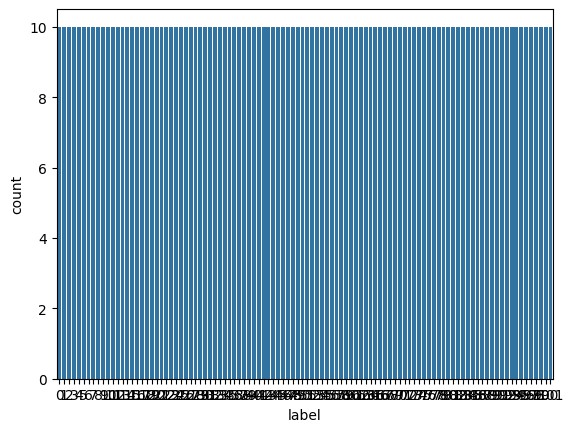

In [46]:
df = train_ds.to_pandas()

sns.countplot(df, x="label")
plt.show()

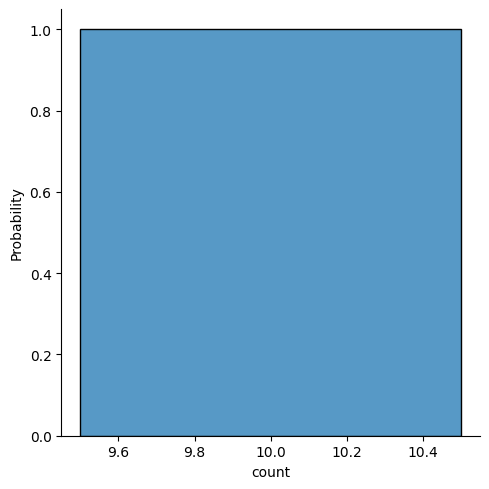

In [52]:
cls_counts = df["label"].value_counts().reset_index()
sns.displot(cls_counts, x="count", discrete=True, stat="probability")

In [42]:
def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

train_ds = train_ds.with_transform(transform)
val_ds   = val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    labels = torch.tensor([b["label"] for b in batch])       # [B]
    return images, labels

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

ClassLabel(names=[' pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-ye

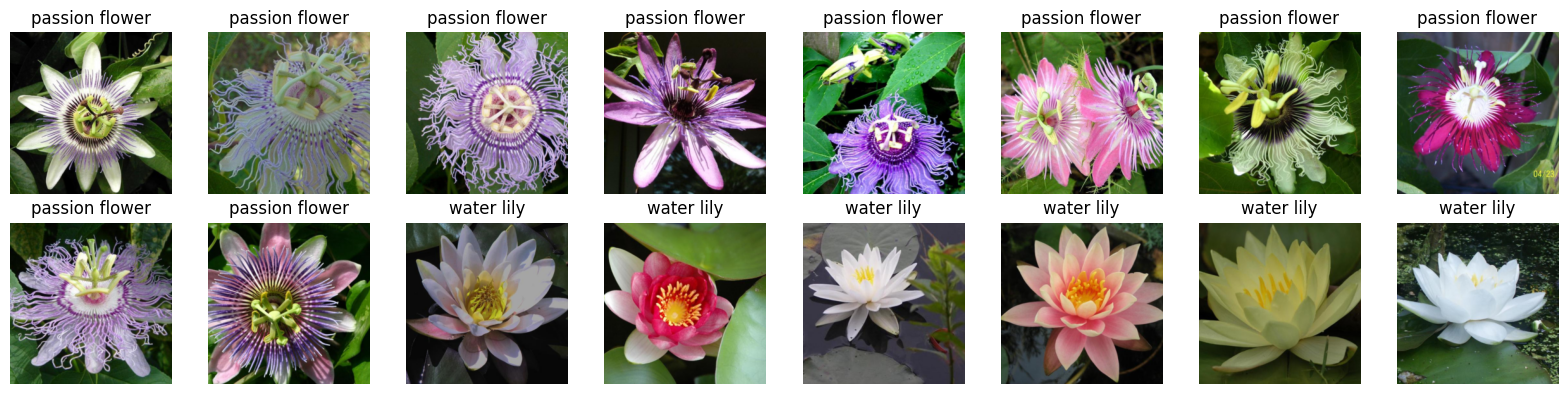

In [43]:
print(train_ds.features["label"])
label_feature = train_ds.features["label"]
classnames = label_feature.names
num_classes = label_feature.num_classes

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [22]:
from collections import defaultdict

def get_fewshot_dataloader(dl, k, *, label_col="label", seed=42):
    ds = dl.dataset
    #orig_tf = getattr(ds, "_transform", None)          # remember HF transform (if any)
    #base = ds.with_transform(None)                     # disable during index selection
    print(ds)

    # collect indices per class (HF: fast column access)
    idx_by_label = defaultdict(list)
    for i, batch in enumerate(ds):
        y = batch[label_col]
        idx_by_label[y].append(i)

    # choose up to k per class, then shuffle globally
    rng = random.Random(seed)
    selected = []
    for idxs in idx_by_label.values():
        rng.shuffle(idxs)
        selected.extend(idxs[:k])
    rng.shuffle(selected)

    subset = ds.select(selected)
    #if orig_tf is not None:
    #    subset = subset.with_transform(orig_tf)

    # rebuild a DataLoader reusing the original settings
    return DataLoader(
        subset,
        batch_size=dl.batch_size or 1,
        shuffle=False,                 # we already shuffled indices
        collate_fn=dl.collate_fn,
        num_workers=dl.num_workers,
        pin_memory=getattr(dl, "pin_memory", False),
        drop_last=getattr(dl, "drop_last", False),
        persistent_workers=getattr(dl, "persistent_workers", False),
    )

In [7]:
class HardcodedPrompt(nn.Module):
    def __init__(self, clip, classnames):
        super().__init__()
        #text_tower = getattr(clip, "text", clip)
        prompts = [f"a photo of a {c}" for c in classnames]
        ## Bad practice to use .to(device) in here, make sure it's a registered buffer
        text_tokens = tokenizer(prompts).to(device)
        text_features = clip.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward_text_features(self):
        return self.text_features

In [8]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, clip, hardcoded_prompt):
        super().__init__()
        self.clip = clip
        self.hardcoded_prompt = hardcoded_prompt

    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = self.hardcoded_prompt.forward_text_features()
            logits = 100.0 * image_features @ text_features.T
        return logits

In [56]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip, tokenizer, classnames, n_ctx=16, init_scale=0.02):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer
        self.classnames = classnames

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.register_buffer('class_token_ids', tokenizer(classnames)) # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.register_buffer('eot_indices', self.class_token_ids.argmax(dim=-1))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward_text_features(self, ctx_override=None):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]


        ctx = self.ctx if ctx_override is None else ctx_override
        # Learnable context repeated across classes
        ctx = ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]
        n_ctx = ctx.shape[0]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(C, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + n_ctx).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=eot.device), eot] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [114]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_prompt):
        super().__init__()
        self.clip = clip
        self.coop_prompt = coop_prompt
        self.clip.requires_grad_(False)
        #self.coop_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.coop_prompt.train()
        else:
          self.clip.eval()
          self.coop_prompt.eval()

    def forward(self, images):
        images = images.to(device)
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = self.coop_prompt.forward_text_features()
        logits = 100.0 * image_features @ text_features.T
        return logits

In [108]:
class MeanCoOpPrompt(nn.Module):
    def __init__(self, coop_prompts, which_require_grad=None):
        super().__init__()
        self.coop_prompts = nn.ModuleList(coop_prompts)

        if which_require_grad == None:
            which_require_grad = [True for _ in range(len(coop_prompts))]

        self.which_require_grad = which_require_grad

        for i, coop_prompt in enumerate(self.coop_prompts):
            coop_prompt.ctx.requires_grad_(self.which_require_grad[i])

    def train(self, mode=True):
        super().train(mode)
        if mode:
            for i, coop_prompt in enumerate(self.coop_prompts):
                coop_prompt.train(self.which_require_grad[i])
        else:
            for i, coop_prompt in enumerate(self.coop_prompts):
                coop_prompt.eval()

    def forward_text_features(self):
        ctxs = torch.stack([p.ctx for p in self.coop_prompts], dim=0)
        ctx_mean = ctxs.mean(dim=0)

        base = self.coop_prompts[0]
        return base.forward_text_features(ctx_override=ctx_mean)


In [11]:
def accuracy(logits, labels):
    preds = logits.argmax(dim=-1)
    correct = (preds == labels).float().mean().item()
    return correct

In [62]:
@torch.no_grad()
def evaluate_classifier(model, test_loader, loss_fn, device, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  for images, labels in iterator:
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    logits = model(images)
    loss = loss_fn(logits, labels)

    bs = labels.size(0)
    loss_sum += loss.item() * bs
    preds = logits.argmax(dim=1)
    correct += (preds == labels).sum().item()
    count += bs

    if pbar:
      acc = (correct / max(1, count)) * 100.0
      iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

  avg_loss = loss_sum / max(1, count)
  avg_acc = correct / max(1, count)
  return avg_loss, avg_acc

def train(
    model, train_loader, val_loader, device="cpu",
    epochs=5, batch_size=256, lr=5e-3, log_train_interval=25, log_val_interval=None
):
    model.to(device)

    print(model.coop_prompt.parameters())

    trainable_params = (p for p in model.parameters() if p.requires_grad)
    optimizer = torch.optim.AdamW(trainable_params, lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_time': [], 'val_time': []
    }

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = evaluate_classifier(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val_time'].append(t)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)
            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            history['train_time'].append(t)
            history['train_loss'].append(loss.item())
            history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

            if log_val_interval and t % log_val_interval == 0:
                val_loss, val_acc = evaluate_classifier(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_time'].append(t)
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )


        avg_train_loss = np.mean(history['train_loss'][-len(train_loader):])
        avg_train_acc = np.mean(history['train_acc'][-len(train_loader):])
        avg_val_loss = history['val_loss'][-1]
        avg_val_acc = history['val_acc'][-1]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    if t > 0:
        val_loss, val_acc = evaluate_classifier(
              model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_time'].append(t)

    return history

In [97]:
clip_model.to(device)

hardcoded_prompt = HardcodedPrompt(
    clip=clip_model,
    classnames=classnames
)

zeroshot_clip = ZeroShotClassifier(
    clip=clip_model,
    hardcoded_prompt=hardcoded_prompt
).to(device)

loss, acc = evaluate_classifier(
    model=zeroshot_clip,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing Zeroshot Clip on full val",
    pbar=True
)
print(f"Accuracy for zeroshot: {acc}")

Testing Zeroshot Clip on full val:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy for zeroshot: 0.696078431372549


In [18]:
coop_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=coop_prompt,
).to(device)

In [19]:
loss, acc = evaluate_classifier(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on val (before training, random prompt)",
    pbar=True
)
print(f"Accuracy before training: {acc}")

Testing CoOpClip on full val:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy before training: 0.5950980392156863


In [ ]:
history = train(
    model=coopclip_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=25,
    log_val_interval=25
)

In [21]:
loss, acc = evaluate_classifier(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
print(f"Accuracy after training: {acc}")

Testing trained CoOpClip on full val:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy after training: 0.8647058823529412


In [29]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    ax = axes[0]
    ax.plot(history['train_time'], history['train_loss'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_loss' in history and len(history['val_time']) and len(history['val_loss']):
        ax.plot(history['val_time'], history['val_loss'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Loss'); ax.set_title('Loss'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    ax = axes[1]
    if 'train_acc' in history and len(history['train_acc']):
        ax.plot(history['train_time'], history['train_acc'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_acc' in history and len(history['val_time']) and len(history['val_acc']):
        ax.plot(history['val_time'], history['val_acc'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Accuracy'); ax.set_title('Accuracy'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    plt.show()

In [30]:
plot_history(history)

NameError: name 'history' is not defined

In [63]:
train_k_loader = get_fewshot_dataloader(train_loader, k=cfg.k_per_class)

Dataset({
    features: ['image', 'label'],
    num_rows: 1020
})


In [64]:
coop_k_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
)

coopclip_k_model = CoOpClip(
    clip=clip_model,
    coop_prompt=coop_k_prompt,
).to(device)

In [ ]:
history = train(
    model=coopclip_k_model,
    train_loader=train_k_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=25,
    log_val_interval=25
)

In [125]:
prompts = []
which_require_grad = []

for i in range(2):
    p = CoOpPrompt(
        clip=clip_model,
        tokenizer=tokenizer,
        classnames=classnames,
        n_ctx=cfg.prompt_len,
    )
    prompts.append(p)
    which_require_grad.append(False)

which_require_grad[0] = True

mean_prompt = MeanCoOpPrompt(prompts, which_require_grad=which_require_grad)

coopclip_mean_model = CoOpClip(
    clip=clip_model,
    coop_prompt=mean_prompt,
).to(device)

In [126]:
history = train(
    model=coopclip_mean_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=25,
    log_val_interval=25
)

<generator object Module.parameters at 0x7ef74a3434c0>


valid:   0%|          | 0/8 [00:00<?, ?it/s]

Before training: val_loss=6.9480  val_acc=1.08%


Epoch 1/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 001: train_loss=5.8785  train_acc=2.36%  val_loss=6.9480  val_acc=1.08%


Epoch 2/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 002: train_loss=4.3468  train_acc=7.46%  val_loss=6.9480  val_acc=1.08%


Epoch 3/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 003: train_loss=3.9379  train_acc=14.46%  val_loss=6.9480  val_acc=1.08%


Epoch 4/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 004: train_loss=3.6975  train_acc=20.60%  val_loss=3.7517  val_acc=17.65%


Epoch 5/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 005: train_loss=3.3913  train_acc=26.87%  val_loss=3.7517  val_acc=17.65%


Epoch 6/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 006: train_loss=3.0608  train_acc=32.75%  val_loss=3.7517  val_acc=17.65%


Epoch 7/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 007: train_loss=2.7542  train_acc=37.84%  val_loss=2.7764  val_acc=38.33%


Epoch 8/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 008: train_loss=2.4916  train_acc=42.94%  val_loss=2.7764  val_acc=38.33%


Epoch 9/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 009: train_loss=2.2422  train_acc=49.05%  val_loss=2.7764  val_acc=38.33%


Epoch 10/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 010: train_loss=2.0071  train_acc=55.60%  val_loss=1.9820  val_acc=56.57%


Epoch 11/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 011: train_loss=1.7990  train_acc=59.68%  val_loss=1.9820  val_acc=56.57%


Epoch 12/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 012: train_loss=1.6329  train_acc=64.33%  val_loss=1.9820  val_acc=56.57%


Epoch 13/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 013: train_loss=1.4943  train_acc=67.84%  val_loss=1.4431  val_acc=67.16%


Epoch 14/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 014: train_loss=1.3790  train_acc=68.82%  val_loss=1.4431  val_acc=67.16%


Epoch 15/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 015: train_loss=1.2895  train_acc=69.98%  val_loss=1.4431  val_acc=67.16%


Epoch 16/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 016: train_loss=1.2160  train_acc=70.79%  val_loss=1.1549  val_acc=71.96%


Epoch 17/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 017: train_loss=1.1578  train_acc=71.99%  val_loss=1.1549  val_acc=71.96%


Epoch 18/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 018: train_loss=1.1187  train_acc=72.06%  val_loss=1.1549  val_acc=71.96%


Epoch 19/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 019: train_loss=1.0805  train_acc=72.95%  val_loss=1.0381  val_acc=75.88%


Epoch 20/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 020: train_loss=1.0454  train_acc=73.43%  val_loss=1.0381  val_acc=75.88%


Epoch 21/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 021: train_loss=1.0065  train_acc=74.31%  val_loss=1.0381  val_acc=75.88%


Epoch 22/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 022: train_loss=0.9750  train_acc=74.70%  val_loss=0.9377  val_acc=75.69%


Epoch 23/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 023: train_loss=0.9440  train_acc=75.87%  val_loss=0.9377  val_acc=75.69%


Epoch 24/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 024: train_loss=0.9072  train_acc=76.56%  val_loss=0.9377  val_acc=75.69%


Epoch 25/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 025: train_loss=0.8738  train_acc=78.15%  val_loss=0.8473  val_acc=78.33%


Epoch 26/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 026: train_loss=0.8434  train_acc=78.34%  val_loss=0.8473  val_acc=78.33%


Epoch 27/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 027: train_loss=0.8178  train_acc=78.94%  val_loss=0.8473  val_acc=78.33%


Epoch 28/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 028: train_loss=0.7823  train_acc=79.53%  val_loss=0.8473  val_acc=78.33%


Epoch 29/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 029: train_loss=0.7573  train_acc=79.10%  val_loss=0.7695  val_acc=80.20%


Epoch 30/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 030: train_loss=0.7317  train_acc=80.10%  val_loss=0.7695  val_acc=80.20%


Epoch 31/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 031: train_loss=0.7047  train_acc=80.29%  val_loss=0.7695  val_acc=80.20%


Epoch 32/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 032: train_loss=0.6712  train_acc=81.27%  val_loss=0.6925  val_acc=81.08%


Epoch 33/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 033: train_loss=0.6395  train_acc=81.98%  val_loss=0.6925  val_acc=81.08%


Epoch 34/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 034: train_loss=0.6136  train_acc=83.24%  val_loss=0.6925  val_acc=81.08%


Epoch 35/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 035: train_loss=0.5924  train_acc=83.14%  val_loss=0.6242  val_acc=82.84%


Epoch 36/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 036: train_loss=0.5732  train_acc=84.32%  val_loss=0.6242  val_acc=82.84%


Epoch 37/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 037: train_loss=0.5564  train_acc=85.46%  val_loss=0.6242  val_acc=82.84%


Epoch 38/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 038: train_loss=0.5530  train_acc=84.03%  val_loss=0.5844  val_acc=83.14%


Epoch 39/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 039: train_loss=0.5363  train_acc=84.80%  val_loss=0.5844  val_acc=83.14%


Epoch 40/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 040: train_loss=0.5088  train_acc=86.08%  val_loss=0.5844  val_acc=83.14%


Epoch 41/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 041: train_loss=0.4973  train_acc=86.45%  val_loss=0.5433  val_acc=85.98%


Epoch 42/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 042: train_loss=0.4868  train_acc=86.86%  val_loss=0.5433  val_acc=85.98%


Epoch 43/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 043: train_loss=0.4701  train_acc=87.37%  val_loss=0.5433  val_acc=85.98%


Epoch 44/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 044: train_loss=0.4484  train_acc=88.25%  val_loss=0.5001  val_acc=87.25%


Epoch 45/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 045: train_loss=0.4381  train_acc=88.22%  val_loss=0.5001  val_acc=87.25%


Epoch 46/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 046: train_loss=0.4268  train_acc=89.21%  val_loss=0.5001  val_acc=87.25%


Epoch 47/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 047: train_loss=0.4105  train_acc=89.80%  val_loss=0.4693  val_acc=87.94%


Epoch 48/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 048: train_loss=0.3971  train_acc=90.40%  val_loss=0.4693  val_acc=87.94%


Epoch 49/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 049: train_loss=0.3894  train_acc=90.39%  val_loss=0.4693  val_acc=87.94%


Epoch 50/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 050: train_loss=0.3769  train_acc=90.40%  val_loss=0.4414  val_acc=89.02%


Epoch 51/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 051: train_loss=0.3825  train_acc=91.07%  val_loss=0.4414  val_acc=89.02%


Epoch 52/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 052: train_loss=0.3589  train_acc=91.16%  val_loss=0.4414  val_acc=89.02%


Epoch 53/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 053: train_loss=0.3465  train_acc=92.07%  val_loss=0.4414  val_acc=89.02%


Epoch 54/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 054: train_loss=0.3310  train_acc=92.84%  val_loss=0.4148  val_acc=89.80%


Epoch 55/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 055: train_loss=0.3235  train_acc=93.13%  val_loss=0.4148  val_acc=89.80%


Epoch 56/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 056: train_loss=0.3162  train_acc=93.64%  val_loss=0.4148  val_acc=89.80%


Epoch 57/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 057: train_loss=0.3075  train_acc=93.60%  val_loss=0.4019  val_acc=90.29%


Epoch 58/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 058: train_loss=0.2941  train_acc=94.40%  val_loss=0.4019  val_acc=90.29%


Epoch 59/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 059: train_loss=0.2832  train_acc=95.38%  val_loss=0.4019  val_acc=90.29%


Epoch 60/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 060: train_loss=0.2793  train_acc=94.80%  val_loss=0.3742  val_acc=90.49%


Epoch 61/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 061: train_loss=0.2682  train_acc=95.59%  val_loss=0.3742  val_acc=90.49%


Epoch 62/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 062: train_loss=0.2632  train_acc=94.99%  val_loss=0.3742  val_acc=90.49%


Epoch 63/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 063: train_loss=0.2582  train_acc=95.28%  val_loss=0.3617  val_acc=91.47%


Epoch 64/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 064: train_loss=0.2509  train_acc=95.78%  val_loss=0.3617  val_acc=91.47%


Epoch 65/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 065: train_loss=0.2391  train_acc=95.98%  val_loss=0.3617  val_acc=91.47%


Epoch 66/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 066: train_loss=0.2363  train_acc=95.58%  val_loss=0.3410  val_acc=91.18%


Epoch 67/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 067: train_loss=0.2373  train_acc=95.89%  val_loss=0.3410  val_acc=91.18%


Epoch 68/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 068: train_loss=0.2291  train_acc=96.16%  val_loss=0.3410  val_acc=91.18%


Epoch 69/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 069: train_loss=0.2290  train_acc=95.98%  val_loss=0.3322  val_acc=91.27%


Epoch 70/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 070: train_loss=0.2257  train_acc=95.96%  val_loss=0.3322  val_acc=91.27%


Epoch 71/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 071: train_loss=0.2121  train_acc=96.67%  val_loss=0.3322  val_acc=91.27%


Epoch 72/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 072: train_loss=0.2093  train_acc=97.16%  val_loss=0.3214  val_acc=91.57%


Epoch 73/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 073: train_loss=0.2019  train_acc=97.25%  val_loss=0.3214  val_acc=91.57%


Epoch 74/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 074: train_loss=0.2021  train_acc=96.37%  val_loss=0.3214  val_acc=91.57%


Epoch 75/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 075: train_loss=0.1978  train_acc=97.06%  val_loss=0.3137  val_acc=92.35%


Epoch 76/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 076: train_loss=0.1911  train_acc=97.16%  val_loss=0.3137  val_acc=92.35%


Epoch 77/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 077: train_loss=0.1887  train_acc=97.27%  val_loss=0.3137  val_acc=92.35%


Epoch 78/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 078: train_loss=0.1847  train_acc=97.25%  val_loss=0.3137  val_acc=92.35%


Epoch 79/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 079: train_loss=0.1829  train_acc=97.85%  val_loss=0.3020  val_acc=93.14%


Epoch 80/80 | train:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 080: train_loss=0.1781  train_acc=97.64%  val_loss=0.3020  val_acc=93.14%


In [ ]:
import torch, hashlib, json

def save_coop_prompt(coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str, classnames: list, n_ctx: int):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    payload = {
        "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
        "meta": {
            "model_name": model_name,
            "pretrained": pretrained,
            "n_ctx": int(n_ctx),
            "classnames": list(classnames),
            # quick fingerprint to catch class order changes
            "classnames_sha1": hashlib.sha1(
                json.dumps(list(classnames), ensure_ascii=False).encode("utf-8")
            ).hexdigest(),
        }
    }
    torch.save(payload, path)


In [ ]:
save_coop_prompt(coopclip_model.coop_prompt, cfg.coop_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained,
                 classnames=classnames, n_ctx=cfg.prompt_len)

In [ ]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  ctx = payload["ctx"]
  n_ctx = payload["meta"]["n_ctx"]
  classnames = payload["meta"]["classnames"]
  model_name = payload["meta"]["model_name"]
  if cfg.model_name != model_name:
    raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.modelname: '{cfg.model_name}'")
  coop_prompt = CoOpPrompt(clip, tokenizer, classnames, n_ctx)
  with torch.no_grad():
    coop_prompt.ctx.copy_(ctx)

  return coop_prompt

In [ ]:
loaded_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_prompt_save_path)

In [ ]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=loaded_prompt,
).to(device)

loss, acc = evaluate_classifier(
    model=loaded_coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for loaded model: {acc}")

### Some more metrics

cm:   0%|          | 0/8 [00:00<?, ?it/s]

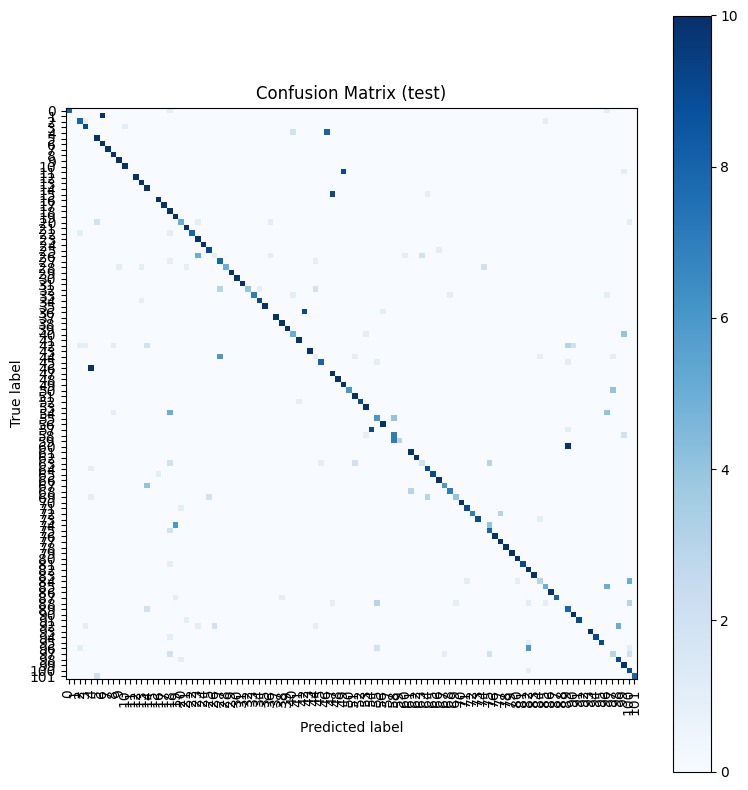

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, classnames=None):
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, leave=False, desc='cm'):
            p = model(x.to(device)).argmax(dim=1).cpu()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(p.tolist())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classnames)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, include_values=False, xticks_rotation=90, cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout(); plt.show()

plot_confusion_matrix(coopclip_k_model)

### Test on real image

In [ ]:
from PIL import Image
image = Image.open("rose_flower.jpg")
plt.imshow(image)
logits = coopclip_model(preprocess(image).unsqueeze(0))
pred = logits.argmax(1)
pred_class = classnames[pred]
print(f"The image is a {pred_class}")